In [1]:
%matplotlib inline

from gscripts.general import dataviz
import os
import seaborn as sns

import pybedtools 
import itertools
import pandas as pd
img_dir = "."
import numpy as np

/home/gpratt/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


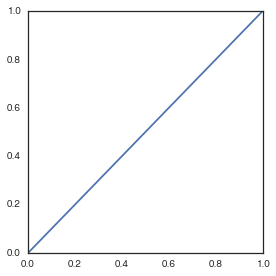

In [2]:
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * 1, 4*1)) as fig:
    ax = fig.add_subplot(1, 1,1)
    ax.plot([0,1], [0,1])

In [3]:
from clipper.src import CLIP_analysis_display, CLIP_analysis


/home/gpratt/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
clip_analysis_100m = CLIP_analysis_display.ClipVisualization(open("/home/gpratt/ad-hoc/region_specific_clip_analysis/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.clip_analysis.pickle"))
assigned_regions, regions = CLIP_analysis.regions_generator()

In [5]:
clip_analysis_100m.phastcons_values.groupby(level=[0,1,2]).mean()

size     covered        sum     mean0      mean
all              rand 0   77.386388   77.265018   9.582032  0.114359  0.114363
                      1   77.386388   77.186050   9.355946  0.113697  0.113701
                      2   77.386388   77.141957   9.758182  0.117996  0.118020
                 real 1   77.386388   77.265939   8.279349  0.104445  0.104448
cds              rand 0  101.348214  101.348214  56.095210  0.612507  0.612507
                      1  101.348214  101.348214  49.106000  0.568678  0.568678
                      2  101.348214  101.348214  49.317464  0.573813  0.573813
                 real 1  101.348214  101.348214  41.333129  0.465609  0.465609
distintron500    rand 0   74.759595   74.520935   4.009637  0.053879  0.053888
                      1   74.759595   74.449407   4.130628  0.056054  0.056055
                      2   74.759595   74.286811   4.494122  0.060180  0.060211
                 real 1   74.759595   74.486043   5.956642  0.081348  0.081353
five_prime_utrs  rand 0   99.315789   99.315789  42.068719  0.442142  0.442142
                      1   99.315789   99.315789  40.295719  0.412494  0.412494
                      2   99.315789   99.315789  26.974404  0.279244  0.279244
                 real 1   99.315789   99.315789  30.650053  0.324777  0.324777
proxintron500    rand 0   77.859065   77.825112   9.743073  0.113965  0.113965
                      1   77.859065   77.726137   9.659547  0.112501  0.112510
                      2   77.859065   77.833120  10.196926  0.117332  0.117354
                 real 1   77.859065   77.859065   6.796407  0.083492  0.083492
three_prime_utrs rand 0   75.033333   75.033333  22.902962  0.298934  0.298934
                      1   75.033333   75.033333  23.357371  0.321980  0.321980
                      2   75.033333   74.387500  25.901637  0.353321  0.353321
                 real 1   75.033333   75.033333  19.143713  0.263432  0.263432
uncatagorized    real 1   79.173391   79.083573   9.374772  0.118039  0.118054

In [6]:
clip_analysis_100m.phastcons_values.xs("real", level=1).groupby(level=0).count()

,size,covered,sum,mean0,mean
all,6509,6509,6509,6509,6509
cds,224,224,224,224,224
distintron500,2866,2866,2866,2866,2866
five_prime_utrs,57,57,57,57,57
proxintron500,3122,3122,3122,3122,3122
three_prime_utrs,240,240,240,240,240
uncatagorized,2082,2082,2082,2082,2082


From the above counts it looks like part of the reason RBFOX2 isn't conserved in 3' UTRs is that it doesn't really bind 3' UTRs

Question
Why is this shit less conserved

Hypothesis: The genes where I have binding are overall less conserved than other non-bound genes

Possible Fix: If I shuffle within transcript the problem will go away.  Problem: If conservation is somewhat uniform across regions I'm up shit creak without a paddle.  



In [7]:
def get_conservation(region, conservation_metric, flush=False):
    out_name = "{}_{}.bed".format(os.path.splitext(os.path.basename(conservation_metric))[0],
                                  os.path.splitext(os.path.basename(region))[0])
        
    if not os.path.exists(out_name) or flush:
        tool = pybedtools.BedTool(region)

        result = []
        for x, interval in enumerate(tool):
            interval.name = "_".join([interval.name, str(x)])
            result.append(interval)

        unique_regions = "{}_unique.bed".format(os.path.splitext(os.path.basename(region))[0])
        pybedtools.BedTool(result).saveas(unique_regions)


        !bigWigAverageOverBed $conservation_metric $unique_regions $out_name
        
    out_df = pd.read_table(out_name, names=["size", "covered", "sum", "mean0", "mean"])
    out_df.index = pd.MultiIndex.from_tuples([item.split("_") for item in out_df.index], names=["gene", "uid"])
    return out_df

def calc_bound_peak_conservation(conservation, peaks):

    bound_genes = set(itertools.chain.from_iterable([interval.name.split(",") for interval in peaks]))
    bound_genes = set(itertools.chain.from_iterable([interval.name.split("|") for interval in peaks]))

    bound_genes = [item.split("_")[0] for item in bound_genes]

    bound_conservation = conservation[conservation.index.isin(bound_genes, level=0)]
    unbound_bound_conservation = conservation[~conservation.index.isin(bound_genes, level=0)]
    return bound_conservation, unbound_bound_conservation

def peak_differences(peak_conservation_df, region_conservation_df):
    index = peak_conservation_df.index
    peak_conservation_df.index = pd.MultiIndex.from_tuples([(item.split("_")[0], x) for x, item in enumerate(index.get_level_values(level=1))], names=['gene', 'uid'])
    peak_conservation_df['location'] = [item.split("_")[-1] for item in index.get_level_values(level=1)]
    peak_conservation_df['gene'] = peak_conservation_df.index.get_level_values(level=0)

    mean_region_conservation_df = region_conservation_df.groupby(level="gene").mean()

    conservation_differences = pd.merge(peak_conservation_df, mean_region_conservation_df, how="left", left_on="gene", right_index=True, suffixes=['_peaks', '_genes'])
    conservation_differences['diff'] = conservation_differences.mean0_peaks - conservation_differences.mean0_genes
    return conservation_differences

In [8]:
class Conservation_Analyzer():
    def __init__(self, clip_analysis, peaks, region, region_name, conservation_file):
        
        self.conservation = get_conservation(region, conservation_file)
        
        self.peaks = pybedtools.BedTool(peaks)
        bound_conservation, unbound_bound_conservation = calc_bound_peak_conservation(self.conservation, self.peaks)
        self.region_name = region_name
        self.bound_conservation = bound_conservation
        self.unbound_bound_conservation = unbound_bound_conservation
        self.conservation_differences = peak_differences(clip_analysis.phastcons_values.ix[region_name, 'real'], self.conservation).dropna()
        
    def plot_conservation(self):
        num_rows = 6 
        num_cols = 2 

        results = {}
        mean_results = {}
        with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
            ax = fig.add_subplot(num_rows, num_cols,1)
            sns.distplot(self.conservation.groupby(level="gene").std().fillna(0)['mean'], ax=ax)
            ax.set_title("Standard Deveation of 3' UTRs in same gene")

            ax = fig.add_subplot(num_rows, num_cols,2)
            sns.distplot(self.conservation.groupby(level="gene").mean()['mean'].fillna(0), ax=ax)
            ax.set_xlim(0,1)
            ax.set_title("Mean Conservation of 3' UTRs")


            ax = fig.add_subplot(num_rows, num_cols,3)
            sns.distplot(self.bound_conservation['mean'].dropna(), label="Bound", hist=False, ax=ax)
            sns.distplot(self.unbound_bound_conservation['mean'].dropna(), label="Unbound", hist=False, ax=ax)
            ax.set_title("Mean Conservation of bound and unbound genes")
            ax.set_xlim(0,1)

            ax = fig.add_subplot(num_rows, num_cols,4)
            #sns.distplot(conservation_differences['diff'].dropna())
            ax.scatter(self.conservation_differences.mean0_peaks, self.conservation_differences.mean0_genes, alpha=.7, color='.7')
            ax.set_title("")
            ax.set_xlim(0,1)
            ax.set_ylim(0,1)
            ax.plot([0,1], [0,1], )
            ax.set_xlabel("Peak Conservation")
            ax.set_ylabel("Region Conservation")
            ax.set_title("Conservation of Peaks vs Regions Peaks are In")

            ax = fig.add_subplot(num_rows, num_cols,5)
            y_pos = np.arange(2)
            ax.bar(y_pos, [sum(self.conservation_differences.mean0_peaks > self.conservation_differences.mean0_genes), 
                           sum(self.conservation_differences.mean0_peaks < self.conservation_differences.mean0_genes)], 
                   align="center", alpha=.7)
            ax.set_xticks(y_pos)
            ax.set_xticklabels(["peaks > region", "region > peaks"])
            ax.set_title("Conservation Differences")
            sns.despine(ax=ax)
            
            ax = fig.add_subplot(num_rows, num_cols,6)
            dataviz.plot_cdf(clip_analysis_100m.phastcons_values.ix[self.region_name, 'real'].mean0.dropna(), ax=ax, label="Real")
            dataviz.plot_cdf(clip_analysis_100m.phastcons_values.ix[self.region_name, 'rand'].mean0.dropna(), ax=ax, label="Random") 
            ax.legend()

            ax = fig.add_subplot(num_rows, num_cols,7)
            dataviz.plot_pdf(clip_analysis_100m.phastcons_values.ix[self.region_name, 'real'].mean0.dropna(), ax=ax, label="Real")
            dataviz.plot_pdf(clip_analysis_100m.phastcons_values.ix[self.region_name, 'rand'].mean0.dropna(), ax=ax, label="Random") 
            ax.legend()

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.260539569056
Conservation in 3' UTR 0.342207392967


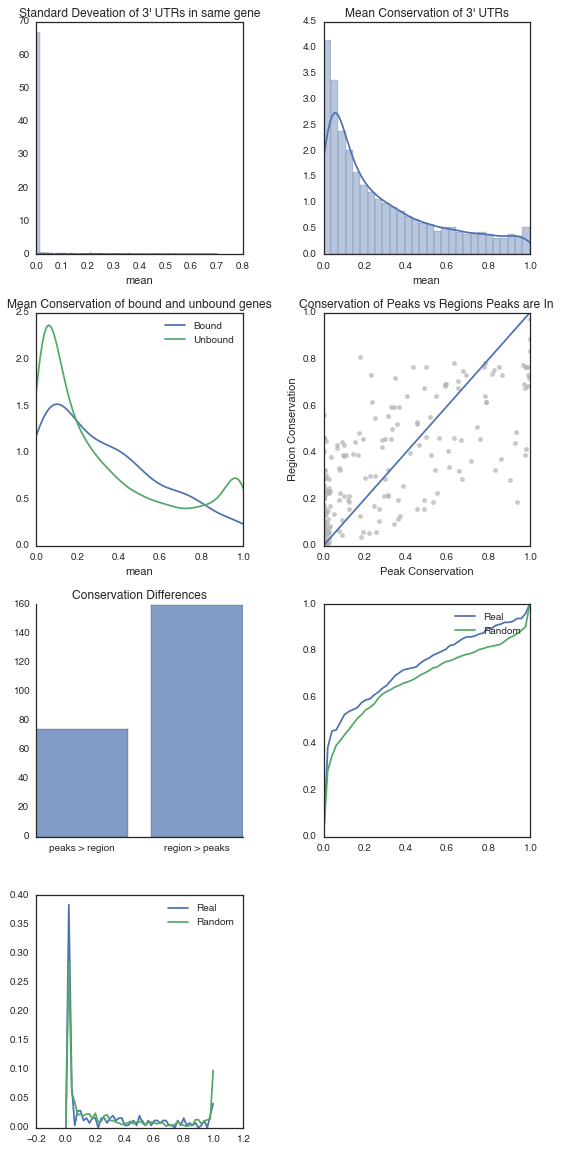

In [9]:
utr3_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.three_prime_utrs.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_three_prime_utrs.bed",
                            region_name="three_prime_utrs",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw")

utr3_plotter.plot_conservation()
print "Conservation in Peaks", utr3_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", utr3_plotter.conservation.mean().mean0

In [10]:
clip_analysis_100m.phastcons_values.ix["three_prime_utrs", 'real']

size  covered      sum  \
1 ENSG00000132879.9_3250_chr1:11721389-11721446         57       57   10.859   
  ENSG00000132879.9_3293,ENSG00000132879.9_3184,E...   211      211    1.953   
  ENSG00000132879.9_3253_chr1:11721797-11721852         55       55    0.026   
  ENSG00000132879.9_3238,ENSG00000132879.9_3300,E...   208      208    5.232   
  ENSG00000020129.11_3479_chr1:36032038-36032162       124      124  102.576   
  ENSG00000092847.6_3426_chr1:36388274-36388330         56       56   40.044   
  ENSG00000142694.6_3807_chr1:36787667-36787714         47       47    5.669   
  ENSG00000214193.5_3169,ENSG00000214193.5_3163,E...   204      204   17.756   
  ENSG00000116337.11_3480_chr1:110174188-110174256      68       68    1.782   
  ENSG00000163399.11_3183_chr1:116947213-116947282      69       69   43.723   
  ENSG00000132694.14_3812_chr1:156905612-156905672      60       60   18.735   
  ENSG00000198756.6_3796_chr1:183905689-183905755       66       66   22.559   
  ENSG00000198625.8_3506_chr1:204520774-204520863       89       89    6.610   
  ENSG00000173726.6_3732_chr1:235274464-235274548       84       84   30.337   
  ENSG00000168209.4_9751_chr10:74035503-74035551        48       48   21.747   
  ENSG00000107854.5_9760_chr10:93624805-93624870        65       65   29.323   
  ENSG00000107957.12_9892_chr10:105360716-105360786     70       70    0.754   
  ENSG00000119927.9_9945_chr10:113912197-113912249      52       52    0.025   
  ENSG00000165672.5_9968_chr10:120927350-120927491     141      141   34.426   
  ENSG00000177542.6_4761_chr11:791142-791199            57       57    0.403   
  ENSG00000162144.5_4816_chr11:61116619-61116668        49       49    0.246   
  ENSG00000162144.5_4779_chr11:61117627-61117679        52       52    1.147   
  ENSG00000134780.5_4477_chr11:61512186-61512288       102      102    1.417   
  ENSG00000134780.5_4487_chr11:61513156-61513229        73       73   14.604   
  ENSG00000149541.5_4617_chr11:62382803-62382923       120      120   94.299   
  ENSG00000149541.5_4755_chr11:62383075-62383137        62       62   48.911   
  ENSG00000167770.7_4314_chr11:63765505-63765636       131      131   10.008   
  ENSG00000073614.7_7909_chr12:391062-391131            69       69    1.474   
  ENSG00000073614.7_7913_chr12:391260-391336            76       76    0.350   
  ENSG00000073614.7_7934_chr12:391414-391465            51       51    1.609   
...                                                    ...      ...      ...   
  ENSG00000164855.11_439_chr7:1585321-1585379           58       58    0.187   
  ENSG00000164855.11_386_chr7:1585534-1585600           66       66    1.593   
  ENSG00000164855.11_304_chr7:1585713-1585779           66       66    0.196   
  ENSG00000164855.11_393_chr7:1586125-1586200           75       75    0.273   
  ENSG00000164855.11_409_chr7:1586236-1586298           62       62    0.117   
  ENSG00000157778.4_620_chr7:1607104-1607153            49       49    0.052   
  ENSG00000242802.2_179_chr7:4831264-4831318            54       54    0.463   
  ENSG00000214253.4_485_chr7:100882806-100882908       102      102   12.841   
  ENSG00000186591.7_504_chr7:129472742-129472801        59       59   50.803   
  ENSG00000104524.9_3128_chr8:144687674-144687735       61       61    0.523   
  ENSG00000178209.10_3014_chr8:144989392-144989452      60       60   36.484   
  ENSG00000178719.12_2853,ENSG00000178719.12_2865...   180      180   93.457   
  ENSG00000178719.12_2906_chr8:145067491-145067542      51       51    8.535   
  ENSG00000213563.2_3129_chr8:145752103-145752160       57       57    0.094   
  ENSG00000147872.5_9452_chr9:19116180-19116229         49       49    1.283   
  ENSG00000107185.8_9160_chr9:35756735-35756836        101      101    0.187   
  ENSG00000107185.8_9157_chr9:35756921-35757051        130      130    0.258   
  ENSG00000107185.8_9207_chr9:35757227-35757300         73       73    0.037   
  ENSG00000135048.9_9444_chr9:74298861-74298978       

In [11]:
utr3_plotter.conservation_differences[(utr3_plotter.conservation_differences.mean0_genes > .1) & (utr3_plotter.conservation_differences.mean0_peaks < .1)]

size_peaks  covered_peaks  sum_peaks  mean0_peaks  \
gene               uid                                                      
ENSG00000116337.11 8            68             68      1.782     0.026206   
ENSG00000107957.12 16           70             70      0.754     0.010771   
ENSG00000119927.9  17           52             52      0.025     0.000481   
ENSG00000177542.6  19           57             57      0.403     0.007070   
ENSG00000134780.5  22          102            102      1.417     0.013892   
ENSG00000167770.7  26          131            131     10.008     0.076397   
ENSG00000073614.7  27           69             69      1.474     0.021362   
                   28           76             76      0.350     0.004605   
                   29           51             51      1.609     0.031549   
                   30           92             92      1.988     0.021609   
ENSG00000111737.7  38           44             44      0.029     0.000659   
ENSG00000013523.5  45           73             73      1.810     0.024795   
ENSG00000090565.11 49           70             70      0.178     0.002543   
ENSG00000197774.8  52           54             54      0.065     0.001204   
                   53           44             44      0.096     0.002182   
ENSG00000140992.14 55           78             78      0.048     0.000615   
ENSG00000167977.4  56           86             86      0.266     0.003093   
ENSG00000140632.12 57           51             51      0.563     0.011039   
ENSG00000124067.12 64           57             57      3.672     0.064421   
ENSG00000187741.10 69           84             84      0.017     0.000202   
ENSG00000108861.4  76           84             84      1.637     0.019488   
ENSG00000136490.4  79           57             57      5.534     0.097088   
ENSG00000132471.7  84          105            105      0.687     0.006543   
ENSG00000167280.12 87           68             68      0.031     0.000456   
                   88           80             80      0.082     0.001025   
                   89           81             81      0.050     0.000617   
ENSG00000169750.4  93           80             80      7.656     0.095700   
ENSG00000091157.9  96           49             49      1.457     0.029735   
ENSG00000116017.6  98           78             78      0.460     0.005897   
ENSG00000076984.13 100          86             86      2.393     0.027826   
                   102          32             32      0.117     0.003656   
ENSG00000179820.11 115          54             54      0.194     0.003593   
ENSG00000167615.12 118          27             27      0.052     0.001926   
                   119          77             77      0.656     0.008519   
ENSG00000133265.6  120          55             55      0.254     0.004618   
ENSG00000115073.6  125          71             71      0.889     0.012521   
ENSG00000135916.11 136          55             55      0.038     0.000691   
ENSG00000144524.13 138          50             50      4.535     0.090700   
ENSG00000085978.17 139          80             80      0.143     0.001788   
ENSG00000149657.15 158          71             71      0.335     0.004718   
ENSG00000100284.16 168          75             75      1.714     0.022853   
ENSG00000189060.4  169          53             53      0.969     0.018283   
                   170          52             52      4.200     0.080769   
ENSG00000144677.10 177          44             44      1.626     0.036955   
ENSG00000163884.3  179         149            149     11.737     0.078772   
ENSG00000185818.7  184          49             49      0.052     0.001061   
ENSG00000124788.13 196          76             76      0.324     0.004263   
ENSG00000213780.6  197          41             41      0.007     0.000171   
ENSG00000187189.9  205          41             41      2.994     0.073024   
ENSG00000198517.5  206          58             58      5.205     0.089741   
ENSG00000107185.8  2

Most genes have little varance in 3' UTRs

So thats what I expected, there are a few highly conserved 3' UTRS that are probably eating up the binding budget, I know from the analysis of different exons, that binding across 3' UTRs isn't totally uniform, so maybe if I do a background shuffle in the same transcript I'll fix my issue.

A quick question I can ask before that, given the conservation score in the peak that that exceede the mean conservation score in the 3' UTR or mean 3' UTR?

Are my targeted genes generally less conserved than non-target genes?

When comparisng the conservation of RBFOX2 peaks to the total conservation of the 3' UTR on average the UTR is MORE conserved than the peak itself

# Same Analysis as above, but with proximal introns

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0831994703356
Conservation in 3' UTR 0.0692265915379


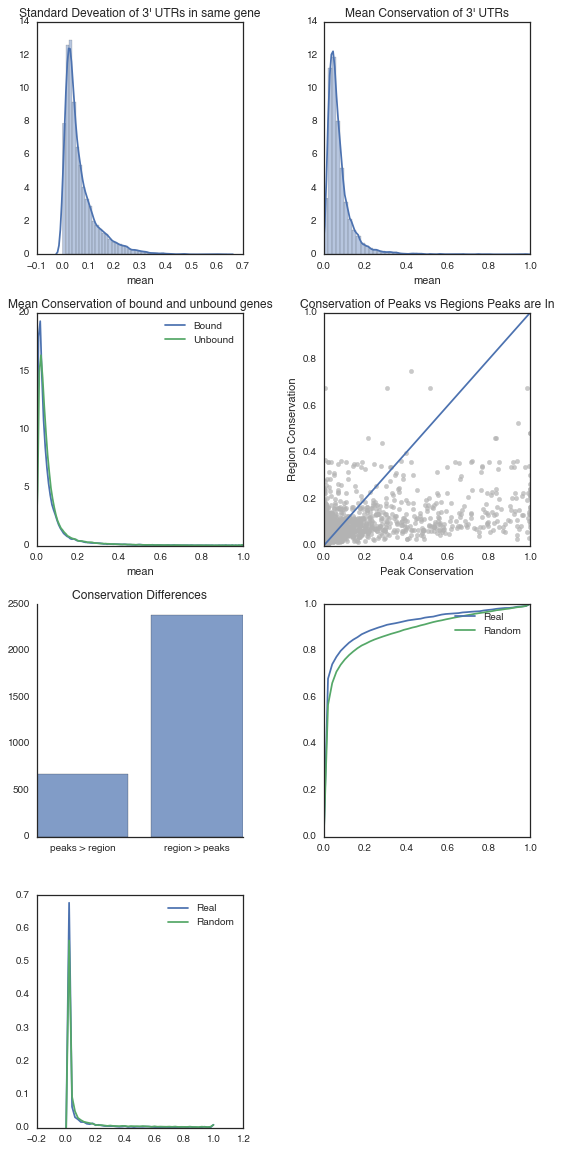

In [12]:
proxintron_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.proxintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_proxintron500.bed",
                            region_name="proxintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw")

proxintron_plotter.plot_conservation()
print "Conservation in Peaks", proxintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", proxintron_plotter.conservation.mean().mean0

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0816465825406
Conservation in 3' UTR 0.0580901608476


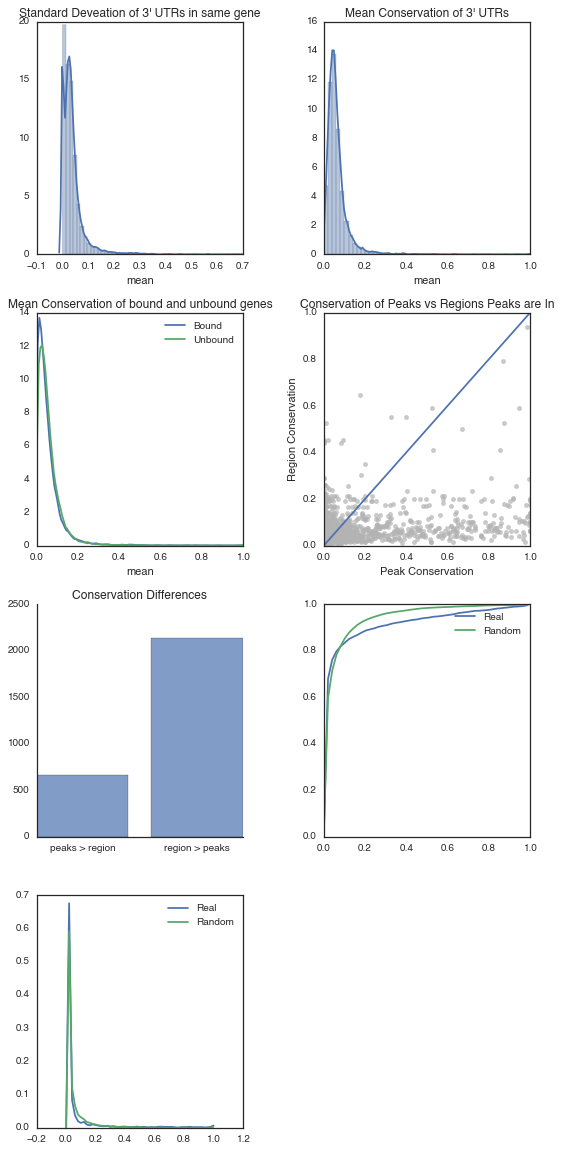

In [13]:
distintron_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.distintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_distintron500.bed",
                            region_name="distintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw")

distintron_plotter.plot_conservation()
print "Conservation in Peaks", distintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", distintron_plotter.conservation.mean().mean0

# Try with all sequenced species 

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.260539569056
Conservation in 3' UTR 0.363302786015


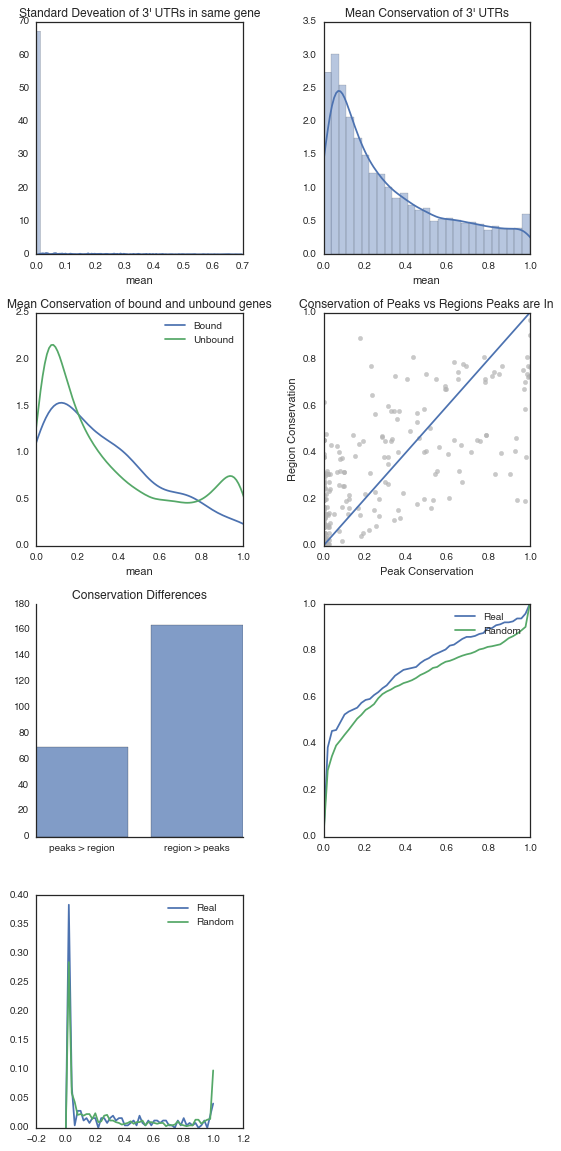

In [14]:
utr3_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.three_prime_utrs.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_three_prime_utrs.bed",
                            region_name="three_prime_utrs",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19.100way.phastCons.bw")

utr3_plotter.plot_conservation()
print "Conservation in Peaks", utr3_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", utr3_plotter.conservation.mean().mean0

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0831994703356
Conservation in 3' UTR 0.0836464928839


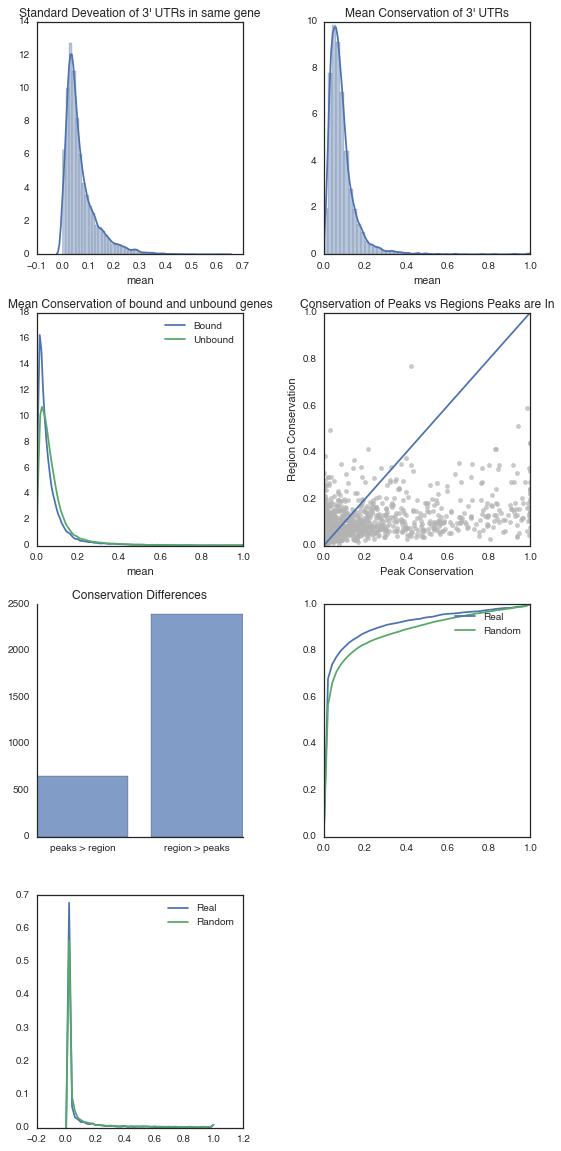

In [15]:
proxintron_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.proxintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_proxintron500.bed",
                            region_name="proxintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19.100way.phastCons.bw")

proxintron_plotter.plot_conservation()
print "Conservation in Peaks", proxintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", proxintron_plotter.conservation.mean().mean0

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0816465825406
Conservation in 3' UTR 0.0699971945213


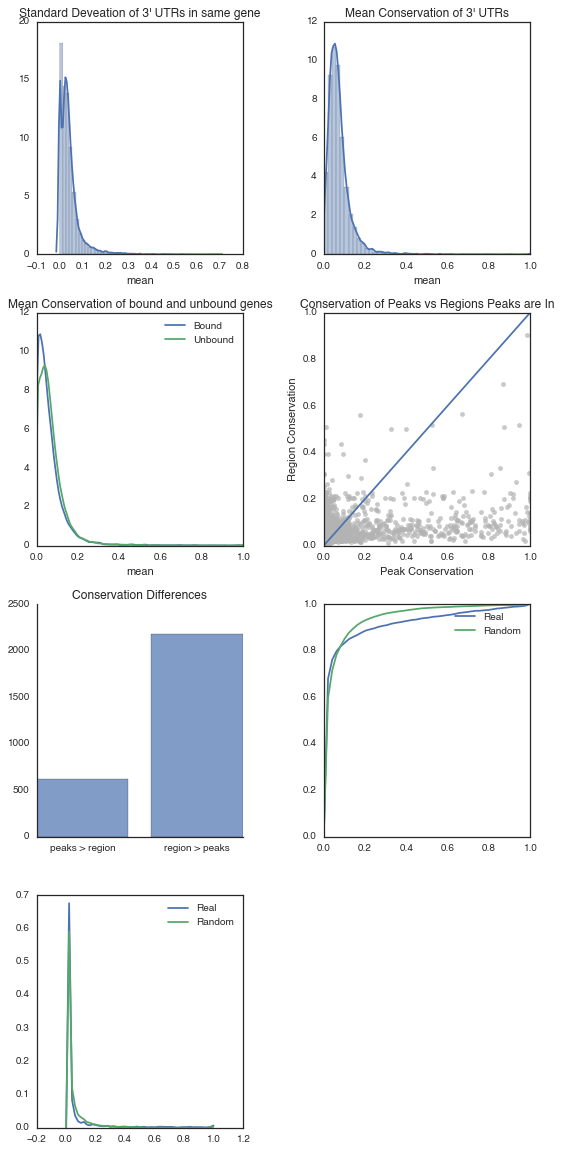

In [16]:
distintron_plotter = Conservation_Analyzer(clip_analysis_100m, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.distintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_distintron500.bed",
                            region_name="distintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19.100way.phastCons.bw")

distintron_plotter.plot_conservation()
print "Conservation in Peaks", distintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", distintron_plotter.conservation.mean().mean0

So the problem is that there are a large number of peaks without ANY conservation.  They look like real peaks (from taking a look at the filtered dataset).  So they just aren't conserved.  There are a subset of peaks that do have conservation, which is good.

To make the CDF significant properly I need to do one of two things.

1) Reduced the number of non-conserved peaks, this i a non-starter because that would involve changing the peak caller.  Also the lowly conserved peaks look pretty good, so why change them? (although maybe the GPS-GEM approach would work)

2) Change the background to have a lower conservation score than it currently does.  There are a few ways to do this

    1) Shuffle only within the same region
    2) Choose a random site in a different gene with the same relative location
    3) Flank the peak 
    
    I've tested option 1, and the results are above.  The important figure that tells me it won't work is the peak conservation vs mean region conservation.  The mean region conservation of the region the peak is bound in is frequently higher than the peak conservation.  That means that shuffling in the same region won't fix my problem.  It totally precludes option 1 and likely precludes option 3 because we are likely to hit other conserved regions in the flank.  Also looking by eye flanking has as many failaure modes as it does sucesses.  
    
    The random site in a different gene also probably won't work for the same region, there are more regions with a higher average conservation than the site I'm looking at.  
    
    Basically no option to change the background will work well because I should raise the true signal, not reduce the background signal.  
    
    I've also tried switching conservation metrics, by eye, and also by global metrics (see analysis above) it doesn't look like it changes much.  I'm going to shelve this until I can get some better input / have a better idea.  



# Whats the average coverage?

In [19]:
bedtools makewindows -b ~/ipython_notebook/encode/hg19_HepG2_three_prime_utrs_unique.bed -n 30 -i srcwinnum > utr3_windows.bed 
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw utr3_windows.bed utr3_windows_conservation.bed
bedtools makewindows -b ~/ipython_notebook/encode/hg19_HepG2_proxintron500_unique.bed -n 30 -i srcwinnum > proxintron500_windows.bed 
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw proxintron500_windows.bed proxintron500_windows_conservation.bed


SyntaxError: invalid syntax (<ipython-input-19-cd74e1603bbe>, line 1)

In [17]:
def parse_coverage(fn):
    
    coverage = pd.read_table(fn, names=["size", "covered", "sum", "mean0", "mean"])
 
    result = []
    for item in coverage.index:
        item = item.split("_") 
        item = [item[0], int(item[1]), int(item[2])]
        result.append(item)
    coverage.index = pd.MultiIndex.from_tuples(result, names=['gene', 'region', 'section']) 
    return coverage

In [18]:
utr3_coverage = parse_coverage("/home/gpratt/ad-hoc/region_windows/utr3_windows_conservation.bed")
proxintron500_coverage = parse_coverage("/home/gpratt/ad-hoc/region_windows/proxintron500_windows_conservation.bed")

In [19]:
utr3_regions = pd.read_table("~/ipython_notebook/encode/hg19_HepG2_three_prime_utrs_unique.bed", 
              names=['chrom', 'start', 'stop', 'name', 'score', 'strand'])
utr3_regions.index = utr3_regions.name
utr3_regions.index = pd.MultiIndex.from_tuples([item.split("_") for item in utr3_regions.index], names=['gene_id', 'region'])

In [20]:
results = []
for name, df in utr3_coverage.mean0.groupby(level=[0,1]):
    strand = utr3_regions.loc[name[0]].strand.values[0]
    
    if strand == "-":
        df.index = pd.MultiIndex.from_tuples(list(reversed(df.index)))
    results.append(df)
    
utr3_coverage = pd.concat(results)

In [21]:
mean_utr3_coverage = utr3_coverage.unstack().mean().sort_index()
mean_proxintron500_coverage = proxintron500_coverage.mean0.unstack().mean().sort_index()

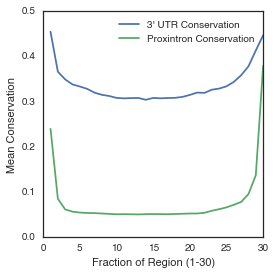

In [22]:
num_cols = 1
num_rows = 1
with dataviz.Figure(os.path.join(img_dir, "foo.svg"), figsize=(4 * num_cols, 4*num_rows)) as fig:
    ax = fig.add_subplot(1,1,1)
    ax.plot(mean_utr3_coverage.index, mean_utr3_coverage.values, label="3' UTR Conservation")
    ax.plot(mean_proxintron500_coverage.index, mean_proxintron500_coverage.values, label="Proxintron Conservation")
    ax.legend()
    ax.set_xlabel("Fraction of Region (1-30)")
    ax.set_ylabel("Mean Conservation")

Shuffling logic

1. For each peak learn distance from start of region (strand specifically)
2. Randmoly select another region
3. Place the peak starts at the same location

# New shuffler development
/home/gpratt/ad-hoc/region_specific_clip_analysis/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper

In [23]:
#foo = CLIP_analysis.assign_to_regions(bedtool)

In [24]:
bedtracks = {}
for region in assigned_regions:
    bedtracks[region] = pybedtools.BedTool(os.path.join("/home/gpratt/clipper/clipper/data/", "regions", "%s_%s.bed" % ("hg19",
                                                                                                      region)))

In [25]:
import clipper

In [26]:
def intersection(a, b=None):
    
    """
    
    A : bedtool
    B : bedtool
    Returns A - B and A intersect B 
    A with b and returns everything in a but not b and everything in a but... ???
    
    """
    
    overlapping = a.intersect(b, wo=True, stream=True)
    overlapping = overlapping.groupby(opCols="4,5,6", ops="first,first,first", full=True).saveas()

    remaining = a.intersect(b, wa=True, v=True, stream=True).saveas()

    return remaining, overlapping

def assign_to_regions(tool, clusters=None, assigned_dir=".", species="hg19", nrand=3):
    
    """
    
    Assigns each cluster to a genic region
    finally saves all generated bed and fasta files for future analysis...

    tool - a bed tool (each line represnting a cluster)
    clusters - name of cluster file (optional)
    assigned_dir - location to save files in
    species - str species to segment
    nrand - int number offsets times to shuffle for null hypothesis


    """
    if clusters is None:
        clusters, ext = os.path.splitext(os.path.basename(tool.fn))
    bedtracks = {}

    regions, assigned_regions = CLIP_analysis.regions_generator()
    short_species = species.split("_")[0]
    if short_species == "GRCh38":
        short_species = "hg38"

    for region in regions:
        bedtracks[region] = pybedtools.BedTool(os.path.join(clipper.data_dir(), "regions", "%s_%s.bed" % (species,
                                                                                                          region)))
    #creates the basics of bed dict
    bed_dict = {'all': {'rand': {}}}

    genes = pybedtools.BedTool(os.path.join(clipper.data_dir(), "regions", "%s_genes.bed" % (species)))

    offsets = CLIP_analysis.get_offsets_bed12(tool)
    if tool.field_count() <= 5:
        tool.sort().merge().saveas()
    elif 6 <= tool.field_count() < 8:
        #Hack to get around not having gene name assigned by peak caller, due to overlapping genes this won't be perfect
        #move_name_real = functools.partial(move_name, original_length=len(tool[0].fields))
        #tool = tool.intersect(genes, wo=True, s=True).each(move_name_real).saveas()
        #fix_strand_ok = functools.partial(fix_strand, warn=False)
        tool = tool.sort().merge(s=True, c="4,5,6", o="collapse,collapse,collapse").each(fix_strand).saveas()
    #elif not tool[0][7].isdigit():
    #    tool = tool.sort().merge(s=True, c="4,5,6", o="collapse,collapse,collapse").each(fix_strand).each(fix_name).saveas()
    else: #Clipper, this is ideal we like this technique
        tool = tool.sort().merge(s=True, c="4,5,6,7,8", o="collapse,collapse,collapse,min,min").each(CLIP_analysis.fix_strand).saveas()

    remaining_clusters = CLIP_analysis.adjust_offsets(tool, offsets)

    # print "There are a total %d clusters I'll examine" % (len(tool))
    for region in regions:
        remaining_clusters, overlapping = intersection(remaining_clusters, b=bedtracks[region])

        #if for some reason there isn't a peak in the region skip it
        if len(overlapping) == 0:
            # print "ignoring %s " % region
            continue

        #sets up bed dict for this region
        bed_dict[region] = {'real': overlapping.sort(stream=True).saveas(),
                            'rand': {}}

        no_overlapping_count = len(remaining_clusters)
        overlapping_count = len(bed_dict[region]['real'])
        # print "For region: %s found %d that overlap and %d that don't" % (region,
        #                                                                   overlapping_count,
        #                                                                   no_overlapping_count)

        if 'real' not in bed_dict['all']:
            bed_dict['all']['real'] = bed_dict[region]['real']
        else:
            bed_dict['all']['real'] = bed_dict['all']['real'].cat(bed_dict[region]['real'], stream=True, postmerge=False).saveas()

        for i in range(nrand):
            random_intervals = shuffle_bedtool(bed_dict[region]['real'], bedtracks[region])
            bed_dict[region]['rand'][i] = random_intervals.saveas()

            if i not in bed_dict['all']['rand']:
                bed_dict['all']['rand'][i] = bed_dict[region]['rand'][i]
            else:
                bed_dict['all']['rand'][i] = bed_dict['all']['rand'][i].cat(bed_dict[region]['rand'][i], stream=True, postmerge=False)


        #if there are no more clusters to assign stop trying
        if no_overlapping_count == 0:
            break

    # print "After assigning %d un-categorized regions" % len(remaining_clusters)

    if len(remaining_clusters) > 0:
        bed_dict['uncatagorized'] = {'real': remaining_clusters.sort(stream=True).saveas()}

    bed_dict = CLIP_analysis.save_bedtools(bed_dict, clusters, assigned_dir)
    return bed_dict

In [27]:
def get_distance_from_start(row):
    if row.strand_peak == "+":
        return row.start_peak - row.start_region
    elif row.strand_peak == "-":
        return row.stop_peak - row.stop_region
    else:
        print "error"
        
def shuffle_bedtool(tool, region):
    merged_df = tool.to_dataframe(names=["chrom_peak", "start_peak", "stop_peak", "name_peak", "score_peak", "strand_peak", "short_start_peak", 
                 "short_stop_peak", "chrom_region", "start_region", "stop_region", "name_region", "score_region", "strand_region", "overlap", "not_sure" "foo", "bar", "baz"])
    
    merged_df['dist'] = merged_df.apply(get_distance_from_start, axis=1)
    merged_df['peak_length'] = merged_df.stop_peak - merged_df.start_peak
    
    region_df = region.to_dataframe()
    random_sample = region_df.sample(n=len(merged_df))
    
    #After setting up the random sample and ish, actually shuffle
    shuffled_bedtool = []
    for (name, peak), (name, new_location) in itertools.izip(merged_df.iterrows(), random_sample.iterrows()):
        if new_location.strand == "+":
            new_peak_start = new_location.start + peak.dist
            new_peak_stop = new_peak_start + peak.peak_length

        if new_location.strand == "-":
            new_peak_stop = new_location.end - peak.dist
            new_peak_start = new_peak_stop - peak.peak_length

        shuffled_bedtool.append(pybedtools.create_interval_from_list([new_location.chrom, 
                                                                      new_peak_start, 
                                                                      new_peak_stop,
                                                                      new_location['name'],
                                                                      peak.score_peak,
                                                                      new_location['strand']]))
    shuffled_bedtool = pybedtools.BedTool(shuffled_bedtool)
    return shuffled_bedtool

In [28]:
tool = pybedtools.BedTool("/home/gpratt/ipython_notebook/encode/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper")
tool = tool.sort().merge(s=True, c="4,5,6,7,8", o="collapse,collapse,collapse,min,min").each(CLIP_analysis.fix_strand).saveas()

In [ ]:
assigned_regions = assign_to_regions(tool, clusters="analysis/specal_shuffle.bed")

In [ ]:
phastcons = CLIP_analysis.calculate_phastcons(assigned_regions, "/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw")

bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw /state/partition1/gpratt/7165522.tscc-mgr.local/pybedtools.FBch41.tmp /home/gpratt/ipython_notebook/encode/./analysis/specal_shuffle.bed.three_prime_utrs.real.tab
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw /state/partition1/gpratt/7165522.tscc-mgr.local/pybedtools.5pt1c1.tmp /home/gpratt/ipython_notebook/encode/./analysis/specal_shuffle.bed.three_prime_utrs.rand.0.tab
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw /state/partition1/gpratt/7165522.tscc-mgr.local/pybedtools.87Xl4v.tmp /home/gpratt/ipython_notebook/encode/./analysis/specal_shuffle.bed.three_prime_utrs.rand.1.tab
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw /state/partition1/gpratt/7165522.tscc-mgr.local/pybedtools.WomoxB.tmp /home/gpratt/ipython_notebook/encode/./analysis/specal_shuffle.bed.three_prime_utrs.rand.2.tab
bigWigAverageOverBed /projects/ps-yeolab/genomes/hg19/

In [36]:
class Foo():
    def __init__(self, phastcons):
        self.phastcons_values = phastcons

In [37]:
foo = Foo(phastcons)


/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0899708906767
Conservation in 3' UTR 0.0692265915379


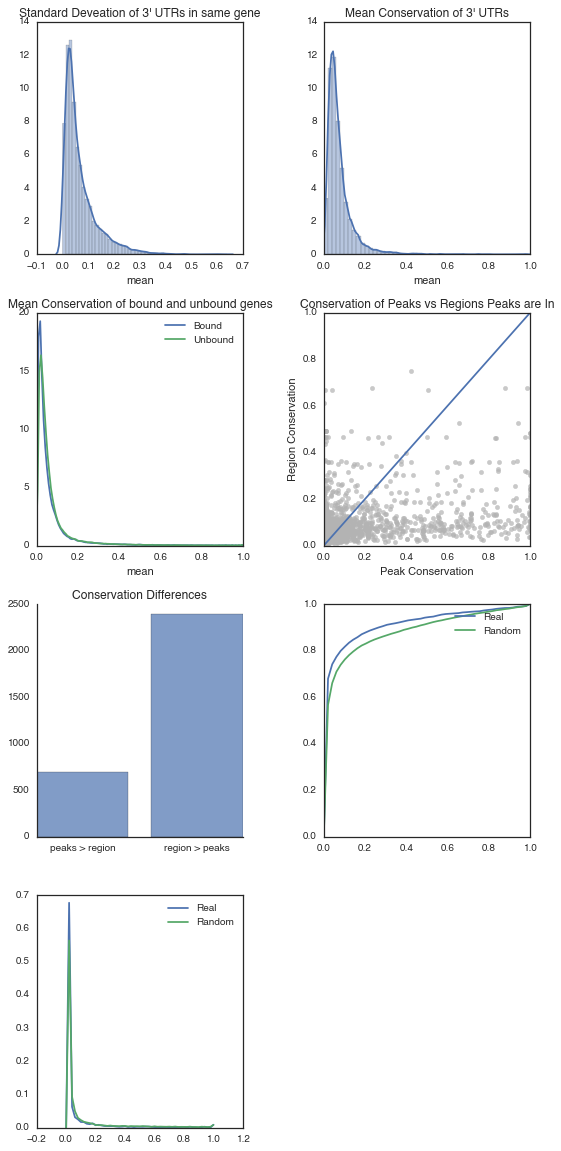

In [38]:
proxintron_plotter = Conservation_Analyzer(foo, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.proxintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_proxintron500.bed",
                            region_name="proxintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19_phastcons.bw")

proxintron_plotter.plot_conservation()
print "Conservation in Peaks", proxintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", proxintron_plotter.conservation.mean().mean0

/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/gpratt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Conservation in Peaks 0.0604332464334
Conservation in 3' UTR 0.0699971945213


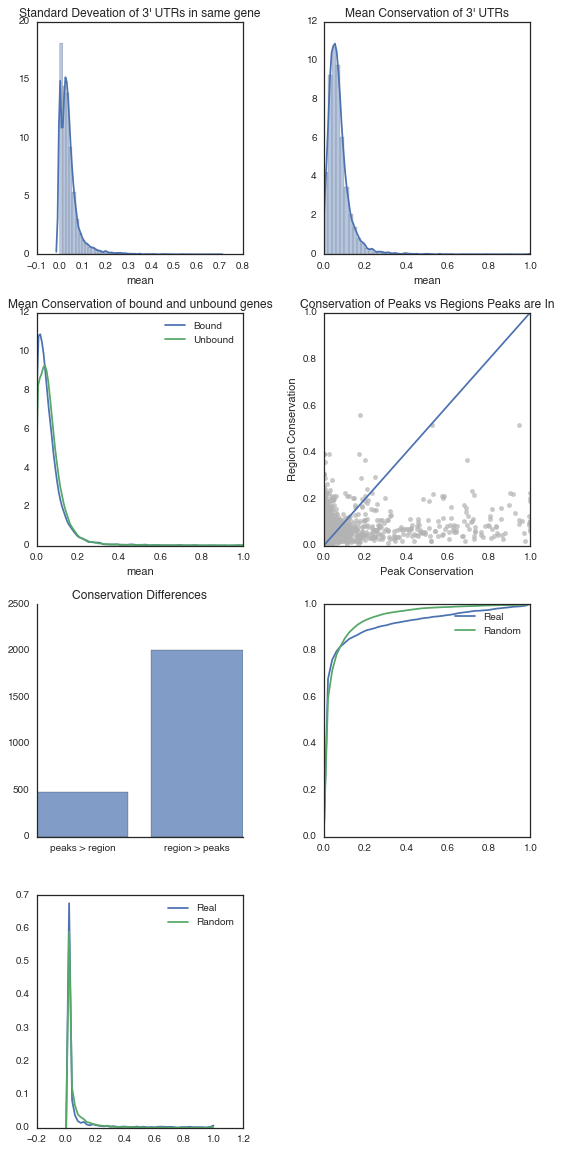

In [39]:
distintron_plotter = Conservation_Analyzer(foo, 
                            peaks="/home/gpratt/ad-hoc/region_specific_clip_analysis/assigned/204_01.basedon_204_01.peaks.l2inputnormnew.bed.compressed.bed.annotated.clipper.distintron500.real.BED",
                            region="/home/gpratt/clipper/clipper/data/regions/hg19_HepG2_distintron500.bed",
                            region_name="distintron500",
                            conservation_file="/projects/ps-yeolab/genomes/hg19/hg19.100way.phastCons.bw")

distintron_plotter.plot_conservation()
print "Conservation in Peaks", distintron_plotter.conservation_differences.mean().mean0_peaks
print "Conservation in 3' UTR", distintron_plotter.conservation.mean().mean0

with this normalization techinque there might be some strangeness overlapping exons that are close by
or overlaps might go into 3' UTRs instead of introns, this should all even out though?  Hopefully, also don't want to make the background too complex

I'll need to fix the overlap weighting issue, first example is stupid, it should be an intronic peak, but instead its exonic because a small sliver is exonic